In [1]:
import os
import torch
import torch.utils.data
from torch import optim, nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST, CelebA
from torchvision.utils import make_grid
from torch.utils.data import dataloader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
!pip install tensorboardx
from tensorboardX import SummaryWriter
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import warnings
warnings.filterwarnings('ignore')
!pip install torchsummary
from torchsummary import summary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.9 MB/s eta 0:00:00


In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI-BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device:{device}")


Using device:cpu


In [4]:
DIRS = {
    'mnist': {
        'data': './data/',
        'checkpoints': './checkpoints/mnist/',
        'tensorboard': './runs/mnist/'
    },
    'celeba': {
        'data': './data/',
        'checkpoints': './checkpoints/celeba/',
        'tensorboard': './runs/celeba/'
    }
}

In [5]:
for model_name, paths in DIRS.items():
  for path in paths.values():
    os.makedirs(path, exist_ok=True)
print("Directories created")

Directories created


In [6]:
for model_name, paths in DIRS.items():
  print(f"Model: {model_name.upper()}")
  for name, path in paths.items():
    print(f"\t{name}: {path}")

Model: MNIST
	data: ./data/
	checkpoints: ./checkpoints/mnist/
	tensorboard: ./runs/mnist/
Model: CELEBA
	data: ./data/
	checkpoints: ./checkpoints/celeba/
	tensorboard: ./runs/celeba/


In [7]:
class Config:
    """Configuration for VAE training."""
    def __init__(self, dataset_name):
        self.dataset_name = dataset_name

        if dataset_name == 'mnist':
            self.image_size = 32
            self.channels = 1
            self.latent_dim = 20
            self.batch_size = 128
            self.epochs = 5
            self.lr = 1e-3
            self.kld_weight = 0.00025
            self.hidden_dims = [32, 64, 128]

        elif dataset_name == 'celeba':
            self.image_size = 128
            self.channels = 3
            self.latent_dim = 128
            self.batch_size = 32
            self.epochs = 35
            self.lr = 1e-3
            self.kld_weight = 0.00025
            self.hidden_dims = [32, 64, 128, 256, 512]

        self.image_dim = self.channels * self.image_size * self.image_size
        self.dirs = DIRS[dataset_name]

    def __repr__(self):
        return (f"Config({self.dataset_name}):\n"
                f"  Image Size: {self.image_size}x{self.image_size}\n"
                f"  Channels: {self.channels}\n"
                f"  Latent Dim: {self.latent_dim}\n"
                f"  Batch Size: {self.batch_size}\n"
                f"  Epochs: {self.epochs}\n"
                f"  Learning Rate: {self.lr}")


In [8]:
print("="*50)
print("MNIST Configuration:")
print("="*50)
print(Config('mnist'))
print("\n" + "="*50)
print("CelebA Configuration:")
print("="*50)
print(Config('celeba'))

MNIST Configuration:
Config(mnist):
  Image Size: 32x32
  Channels: 1
  Latent Dim: 20
  Batch Size: 128
  Epochs: 5
  Learning Rate: 0.001

CelebA Configuration:
Config(celeba):
  Image Size: 128x128
  Channels: 3
  Latent Dim: 128
  Batch Size: 32
  Epochs: 35
  Learning Rate: 0.001


In [9]:
class VAE(nn.Module):
    def __init__(self, in_channels=3, image_size=128, latent_dim=128,hidden_dims=None):
        super(VAE, self).__init__()

        self.image_size = image_size
        self.in_channels = in_channels
        self.latent_dim = latent_dim

        # Encoder architecture
        if hidden_dims is None:
            if image_size <= 32:
                hidden_dims = [32, 64, 128]
            elif image_size <= 64:
                hidden_dims = [32, 64, 128, 256]
            else:
                hidden_dims = [32, 64, 128, 256, 512]
        self.hidden_dims = hidden_dims.copy()
        self.final_dim = hidden_dims[-1]

        # Build Encoder
        modules = []
        channels = in_channels
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            channels = h_dim
        self.encoder = nn.Sequential(*modules)

        # Calculate encoder output size dynamically
        with torch.no_grad():
            dummy = torch.zeros(2, in_channels, image_size, image_size)
            out = self.encoder(dummy)
            self.enc_out_size = out.shape[2]
            self.flatten_size = hidden_dims[-1] * self.enc_out_size * self.enc_out_size

        # Latent space
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)

        # Build Decoder
        self.decoder_input = nn.Linear(latent_dim, self.flatten_size)

        hidden_dims.reverse()
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU()
                )
            )
        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=in_channels,
                      kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        self.output_transform = transforms.Resize(image_size, antialias=True)

    def encode(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, self.final_dim, self.enc_out_size, self.enc_out_size)
        result = self.decoder(result)
        result = self.final_layer(result)
        result = self.output_transform(result)
        return result

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

    def sample(self, num_samples, device):
        z = torch.randn(num_samples, self.latent_dim).to(device)
        return self.decode(z)

In [10]:
model = VAE()
print(model)

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequentia

In [11]:
from torchsummary import summary
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         LeakyReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         295,168
      BatchNorm2d-11            [-1, 256, 8, 8]             512
        LeakyReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

In [12]:
def get_data_loaders(config):
    if config.dataset_name == 'mnist':
        transform = transforms.Compose([
            transforms.Resize(config.image_size),
            transforms.ToTensor(),
        ])

        train_dataset = MNIST(config.dirs['data'], transform=transform,
                              download=True, train=True)
        test_dataset = MNIST(config.dirs['data'], transform=transform,
                             download=True, train=False)

    elif config.dataset_name == 'celeba':
        transform = transforms.Compose([
            transforms.Resize(config.image_size, antialias=True),
            transforms.CenterCrop(config.image_size),
            transforms.ToTensor(),
        ])

        # train_dataset = CelebA(config.dirs['data'], transform=transform,
        #                        download=True, split='train')
        # test_dataset = CelebA(config.dirs['data'], transform=transform,
        #                       download=True, split='valid')

        full_dataset = ImageFolder(
        root=os.path.join(config.dirs['data'], 'celeba'),
        transform=transform
        )

        train_size = int(0.9 * len(full_dataset))
        val_size = len(full_dataset) - train_size

        train_dataset, test_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size,
                              shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size,
                             shuffle=False, num_workers=4, pin_memory=True)

    print(f"\n{config.dataset_name.upper()} Dataset loaded:")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")

    return train_loader, test_loader

In [13]:
def vae_loss(recon_x, x, mu, log_var, config):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x.view(-1, config.image_dim),
                            x.view(-1, config.image_dim), reduction='mean')

    # KL Divergence
    kld = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    total_loss = recon_loss + config.kld_weight * kld

    return total_loss, recon_loss, kld

In [14]:
class Trainer:
    def __init__(self, model, config, train_loader, test_loader):
        self.model = model
        self.config = config
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optim.Adam(model.parameters(), lr=config.lr)

        # TensorBoard writer
        self.writer = SummaryWriter(config.dirs['tensorboard'])

        # Best model tracking
        self.best_val_loss = float('inf')
        self.best_epoch = 0

        # History
        self.train_losses = []
        self.val_losses = []
        self.recon_losses = []
        self.kld_losses = []

    def validate(self, epoch):
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for data, _ in self.test_loader:
                data = data.to(device)
                recon_batch, mu, log_var = self.model(data)
                loss, _, _ = vae_loss(recon_batch, data, mu, log_var, self.config)
                total_loss += loss.item()

        avg_loss = total_loss / len(self.test_loader)

        # Save best model
        if avg_loss < self.best_val_loss:
            self.best_val_loss = avg_loss
            self.best_epoch = epoch
            self.save_checkpoint(epoch, is_best=True)
            print(f'    *** New best model saved! Val Loss: {avg_loss:.6f} ***', flush=True)

        return avg_loss

    def save_checkpoint(self, epoch, is_best=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': self.best_val_loss,
            'config': {
                'in_channels': self.config.channels,
                'image_size': self.config.image_size,
                'latent_dim': self.config.latent_dim,
            },
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
        }

        if is_best:
            path = os.path.join(self.config.dirs['checkpoints'], 'best_model.pth')
        else:
            path = os.path.join(self.config.dirs['checkpoints'], f'checkpoint_epoch_{epoch}.pth')

        torch.save(checkpoint, path)

    def log_to_tensorboard(self, epoch, train_loss, val_loss, recon_loss, kld_loss):
        self.writer.add_scalar('Loss/train', train_loss, epoch)
        self.writer.add_scalar('Loss/validation', val_loss, epoch)
        self.writer.add_scalar('Loss/reconstruction', recon_loss, epoch)
        self.writer.add_scalar('Loss/kld', kld_loss, epoch)

        # Log reconstructions
        self.model.eval()
        with torch.no_grad():
            data, _ = next(iter(self.test_loader))
            data = data[:8].to(device)
            recon, _, _ = self.model(data)

            comparison = torch.cat([data, recon])
            grid = make_grid(comparison, nrow=8, normalize=True)
            self.writer.add_image('Reconstructions', grid, epoch)

            # Generated samples
            samples = self.model.sample(16, device)
            grid = make_grid(samples, nrow=8, normalize=True)
            self.writer.add_image('Generated', grid, epoch)

    def log_latent_space_tsne(self, epoch, num_samples=2000):
        self.model.eval()

        latents = []
        labels = []

        with torch.no_grad():
            for data, label in self.test_loader:
                data = data.to(device)
                mu, _ = self.model.encode(data)
                latents.append(mu.cpu())
                labels.append(label)

                if len(latents) * self.config.batch_size >= num_samples:
                    break

        latents = torch.cat(latents)[:num_samples].numpy()
        labels = torch.cat(labels)[:num_samples].numpy()

        # 2D t-SNE
        print(f"    Computing 2D t-SNE...", flush=True)
        tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
        latents_2d = tsne_2d.fit_transform(latents)

        # 3D t-SNE
        print(f"    Computing 3D t-SNE...", flush=True)
        tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
        latents_3d = tsne_3d.fit_transform(latents)

        # Log embeddings to TensorBoard
        # For 2D visualization
        self.writer.add_embedding(
            torch.tensor(latents_2d),
            metadata=labels.tolist(),
            tag=f'latent_space_2d_epoch_{epoch}',
            global_step=epoch
        )

        # For 3D visualization
        self.writer.add_embedding(
            torch.tensor(latents_3d),
            metadata=labels.tolist(),
            tag=f'latent_space_3d_epoch_{epoch}',
            global_step=epoch
        )

        return latents_2d, latents_3d, labels

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        total_recon = 0
        total_kld = 0

        for batch_idx, (data, _) in enumerate(self.train_loader):
            data = data.to(device)
            self.optimizer.zero_grad()

            recon_batch, mu, log_var = self.model(data)
            log_var = torch.clamp(log_var, -10, 10)

            loss, recon, kld = vae_loss(recon_batch, data, mu, log_var, self.config)

            loss.backward()
            total_loss += loss.item()
            total_recon += recon.item()
            total_kld += kld.item()
            self.optimizer.step()

            if batch_idx % 100 == 0:
                print(f'    Batch [{batch_idx * len(data)}/{len(self.train_loader.dataset)} '
                      f'({100. * batch_idx / len(self.train_loader):.0f}%)] '
                      f'Loss: {loss.item():.6f}', flush=True)

        avg_loss = total_loss / len(self.train_loader)
        avg_recon = total_recon / len(self.train_loader)
        avg_kld = total_kld / len(self.train_loader)

        return avg_loss, avg_recon, avg_kld

    def train(self):
        """Full training loop."""
        print(f"\n{'='*60}")
        print(f"Starting training for {self.config.dataset_name.upper()}")
        print(f"{'='*60}")

        for epoch in range(1, self.config.epochs + 1):
            print(f"\nEpoch {epoch}/{self.config.epochs}")
            print("-" * 40)

            # Train
            train_loss, recon_loss, kld_loss = self.train_epoch(epoch)
            print(f"  Train Loss: {train_loss:.6f} (Recon: {recon_loss:.6f}, KLD: {kld_loss:.6f})")

            # Validate
            val_loss = self.validate(epoch)
            print(f"  Val Loss: {val_loss:.6f}")

            # Store history
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.recon_losses.append(recon_loss)
            self.kld_losses.append(kld_loss)

            # Log to TensorBoard
            self.log_to_tensorboard(epoch, train_loss, val_loss, recon_loss, kld_loss)

            # Log t-SNE at specific epochs
            if epoch == 1 or epoch == self.config.epochs or epoch % 5 == 0:
                self.log_latent_space_tsne(epoch)

        self.writer.close()
        print(f"\n{'='*60}")
        print(f"Training complete!")
        print(f"Best model at epoch {self.best_epoch} with val loss: {self.best_val_loss:.6f}")
        print(f"{'='*60}")

        return self.train_losses, self.val_losses

In [15]:
def show_images(images, title="", nrow=8, figsize=(12, 12), cmap=None):
    grid = make_grid(images.cpu().detach(), nrow=nrow, normalize=True, padding=2)
    plt.figure(figsize=figsize)
    img = grid.permute(1, 2, 0).numpy()
    if img.shape[2] == 1:
        img = img.squeeze(2)
        cmap = 'gray'
    plt.imshow(img, cmap=cmap)
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

In [17]:
def plot_training_curves(train_losses, val_losses, title="Training Curves"):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [18]:
def show_reconstruction(model, test_loader, config, num_images=10):

    model.eval()
    data, _ = next(iter(test_loader))
    data = data[:num_images].to(device)

    with torch.no_grad():
        recon, _, _ = model(data)

    comparison = torch.cat([data, recon])

    grid = make_grid(comparison.cpu(), nrow=num_images, normalize=True, padding=2)
    plt.figure(figsize=(15, 4))
    img = grid.permute(1, 2, 0).numpy()
    if img.shape[2] == 1:
        img = img.squeeze(2)
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title('Top: Original | Bottom: Reconstructed', fontsize=14)
    plt.axis('off')
    plt.show()

In [19]:
def generate_samples(model, config, num_samples=64):
    model.eval()
    with torch.no_grad():
        samples = model.sample(num_samples, device)
    show_images(samples, title=f"Generated Samples ({config.dataset_name.upper()})",
                nrow=8, figsize=(12, 12))

In [20]:
def show_latent_interpolation(model, config, num_steps=10):
    model.eval()

    with torch.no_grad():
        z1 = torch.randn(1, config.latent_dim).to(device)
        z2 = torch.randn(1, config.latent_dim).to(device)

        interpolations = []
        for alpha in np.linspace(0, 1, num_steps):
            z = (1 - alpha) * z1 + alpha * z2
            img = model.decode(z)
            interpolations.append(img)

        interpolations = torch.cat(interpolations)

    show_images(interpolations, title="Latent Space Interpolation",
                nrow=num_steps, figsize=(15, 2))

In [21]:
def plot_latent_space_2d(latents_2d, labels, title="Latent Space (2D t-SNE)"):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1],
                         c=labels, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Class')
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [22]:
def plot_latent_space_3d(latents_3d, labels, title="Latent Space (3D t-SNE)"):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(latents_3d[:, 0], latents_3d[:, 1], latents_3d[:, 2],
                        c=labels, cmap='tab10', alpha=0.6, s=10)

    ax.set_xlabel('t-SNE Dim 1', fontsize=10)
    ax.set_ylabel('t-SNE Dim 2', fontsize=10)
    ax.set_zlabel('t-SNE Dim 3', fontsize=10)
    ax.set_title(title, fontsize=14)

    plt.colorbar(scatter, label='Class', shrink=0.5)
    plt.tight_layout()
    plt.show()

In [23]:
def iterative_reconstruction(model, test_loader, config, num_iterations=7):
    model.eval()
    data, label = next(iter(test_loader))
    pic = data[0:1].to(device)

    pics = [pic]
    current = pic

    with torch.no_grad():
        for _ in range(num_iterations):
            recon, _, _ = model(current)
            current = recon
            pics.append(current)

    pics = torch.cat(pics)

    grid = make_grid(pics.cpu(), nrow=num_iterations+1, normalize=True, padding=2)
    plt.figure(figsize=(15, 2))
    img = grid.permute(1, 2, 0).numpy()
    if img.shape[2] == 1:
        img = img.squeeze(2)
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title('Iterative Reconstruction (Original → Reconstructions)', fontsize=14)
    plt.axis('off')
    plt.show()

In [24]:
def load_best_model(config):
    checkpoint_path = os.path.join(config.dirs['checkpoints'], 'best_model.pth')

    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model_config = checkpoint['config']

    model = VAE(
        in_channels=model_config['in_channels'],
        image_size=model_config['image_size'],
        latent_dim=model_config['latent_dim']
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"Loaded best model from epoch {checkpoint['epoch']}")
    print(f"Validation loss: {checkpoint['val_loss']:.6f}")

    return model, checkpoint

In [25]:
def compute_tsne(model, test_loader, config, num_samples=2000):
    model.eval()

    latents = []
    labels = []

    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu())
            labels.append(label)

            if len(latents) * config.batch_size >= num_samples:
                break

    latents = torch.cat(latents)[:num_samples].numpy()
    labels = torch.cat(labels)[:num_samples].numpy()

    if len(labels.shape) > 1:
        labels = labels[:, 0]

    print("Computing 2D t-SNE...")
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
    latents_2d = tsne_2d.fit_transform(latents)

    print("Computing 3D t-SNE...")
    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
    latents_3d = tsne_3d.fit_transform(latents)

    return latents_2d, latents_3d, labels

In [26]:
mnist_config = Config('mnist')
print(mnist_config)

Config(mnist):
  Image Size: 32x32
  Channels: 1
  Latent Dim: 20
  Batch Size: 128
  Epochs: 5
  Learning Rate: 0.001


In [27]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader

mnist_train_loader, mnist_test_loader = get_data_loaders(mnist_config)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.52MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.8MB/s]


MNIST Dataset loaded:
  Training samples: 60000
  Test samples: 10000


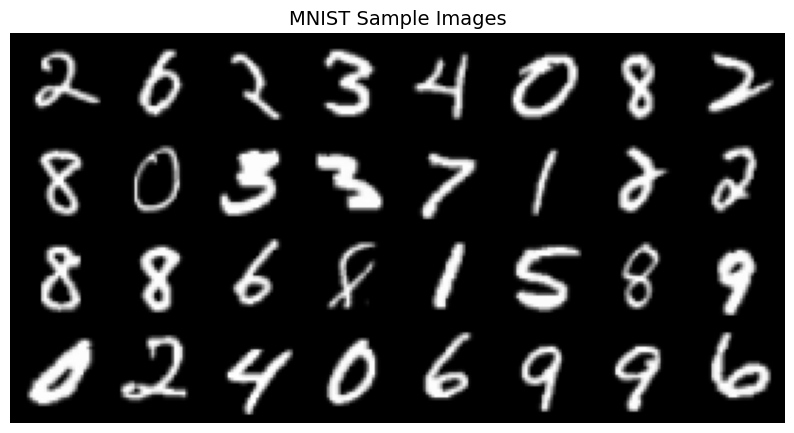

In [28]:
sample_data, sample_labels = next(iter(mnist_train_loader))
show_images(sample_data[:32], title="MNIST Sample Images", nrow=8, figsize=(10, 10))


In [6]:
mnist_model = VAE(
    in_channels=mnist_config.channels,
    image_size=mnist_config.image_size,
    latent_dim=mnist_config.latent_dim,
    hidden_dims=mnist_config.hidden_dims
).to(device)

print(f"\nMNIST VAE Model:")
print(f"  Parameters: {sum(p.numel() for p in mnist_model.parameters()):,}")

NameError: name 'VAE' is not defined

In [5]:
mnist_model = VAE(
    in_channels=mnist_config.channels,
    image_size=mnist_config.image_size,
    latent_dim=mnist_config.latent_dim,
    hidden_dims=mnist_config.hidden_dims
).to(device)

print(f"\nMNIST VAE Model:")
print(f"  Parameters: {sum(p.numel() for p in mnist_model.parameters()):,}")

mnist_trainer = Trainer(mnist_model, mnist_config, mnist_train_loader, mnist_test_loader)
mnist_train_losses, mnist_val_losses = mnist_trainer.train()

NameError: name 'VAE' is not defined

In [1]:
plot_training_curves(mnist_train_losses, mnist_val_losses, title="MNIST Training Curves")

NameError: name 'plot_training_curves' is not defined

In [ ]:
mnist_best_model, mnist_checkpoint = load_best_model(mnist_config)

In [ ]:
mnist_best_model, mnist_checkpoint = load_best_model(mnist_config)

In [ ]:
generate_samples(mnist_best_model, mnist_config, num_samples=64)

In [ ]:
show_latent_interpolation(mnist_best_model, mnist_config, num_steps=12)

In [ ]:
iterative_reconstruction(mnist_best_model, mnist_test_loader, mnist_config, num_iterations=7)

In [ ]:
iterative_reconstruction(mnist_best_model, mnist_test_loader, mnist_config, num_iterations=7)

In [ ]:
plot_latent_space_2d(mnist_latents_2d, mnist_labels,
                     title="MNIST Latent Space (2D t-SNE)")


In [ ]:
plot_latent_space_2d(mnist_latents_2d, mnist_labels,
                        title="MNIST Latent Space (2D t-SNE)")


In [ ]:
celebar_config = Config('celebar')
print(celebar_config)

In [ ]:
celebar_train_loader, celebar_test_loader = get_data_loaders(celebar_config)

In [ ]:
sample_data, sample_labels = next(iter(celeba_train_loader))
show_images(sample_data[:32], title="CelebA Sample Images", nrow=8, figsize=(12, 12))

In [ ]:
celeba_model = VAE(
    in_channels=celeba_config.channels,
    image_size=celeba_config.image_size,
    latent_dim=celeba_config.latent_dim
).to(device)

In [ ]:
print(f"\nCelebA VAE Model:")
print(f"  Parameters: {sum(p.numel() for p in celeba_model.parameters()):,}")


In [ ]:
celeba_trainer = Trainer(celeba_model, celeba_config, celeba_train_loader, celeba_test_loader)
celeba_train_losses, celeba_val_losses = celeba_trainer.train()


In [ ]:
plot_training_curves(celeba_train_losses, celeba_val_losses,
                     title="CelebA VAE Training Curves")

In [ ]:
celeba_best_model, celeba_checkpoint = load_best_model(celeba_config)

In [ ]:
show_reconstruction(celeba_best_model, celeba_test_loader, celeba_config, num_images=8)

In [ ]:
generate_samples(celeba_best_model, celeba_config, num_samples=64)

In [ ]:
show_latent_interpolation(celeba_best_model, celeba_config, num_steps=10)


In [ ]:
iterative_reconstruction(celeba_best_model, celeba_test_loader, celeba_config, num_iterations=7)


In [ ]:
celeba_latents_2d, celeba_latents_3d, celeba_labels = compute_tsne(
    celeba_best_model, celeba_test_loader, celeba_config, num_samples=2000
)

In [ ]:
plot_latent_space_2d(celeba_latents_2d, celeba_labels,
                     title="CelebA Latent Space (2D t-SNE)")


In [ ]:
plot_latent_space_3d(celeba_latents_3d, celeba_labels,
                     title="CelebA Latent Space (3D t-SNE)")


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MNIST losses
axes[0].plot(mnist_train_losses, 'b-', label='Train', linewidth=2)
axes[0].plot(mnist_val_losses, 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('MNIST VAE Training')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[1].plot(celeba_train_losses, 'b-', label='Train', linewidth=2)
axes[1].plot(celeba_val_losses, 'r-', label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('CelebA VAE Training')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*70)
print("                         SUMMARY")
print("="*70)
print(f"\nMNIST VAE:")
print(f"  Best Epoch: {mnist_checkpoint['epoch']}")
print(f"  Best Val Loss: {mnist_checkpoint['val_loss']:.6f}")
print(f"  Checkpoint: {mnist_config.dirs['checkpoints']}best_model.pth")
print(f"  TensorBoard: {mnist_config.dirs['tensorboard']}")

print(f"\nCelebA VAE:")
print(f"  Best Epoch: {celeba_checkpoint['epoch']}")
print(f"  Best Val Loss: {celeba_checkpoint['val_loss']:.6f}")
print(f"  Checkpoint: {celeba_config.dirs['checkpoints']}best_model.pth")
print(f"  TensorBoard: {celeba_config.dirs['tensorboard']}")

print("\n" + "="*70)
print("To view TensorBoard logs, run:")
print("  tensorboard --logdir=./runs/")
print("="*70)

In [ ]:
generate_samples(mnist_best_model, mnist_config, num_samples=100)

In [ ]:
generate_samples(celeba_best_model, celeba_config, num_samples=64)


In [ ]:
def generate_digit_grid(model, config, n=15):
    """Generate a grid by sampling the first two latent dimensions uniformly."""
    model.eval()

    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)

    images = []

    with torch.no_grad():
        for yi in grid_y:
            for xi in grid_x:
                z = torch.zeros(1, config.latent_dim).to(device)
                z[0, 0] = xi
                z[0, 1] = yi
                sample = model.decode(z)
                images.append(sample)

    images = torch.cat(images)
    show_images(images, title='Latent Space Grid (z[0] vs z[1])', nrow=n, figsize=(14, 14))


In [ ]:
generate_digit_grid(mnist_best_model, mnist_config, n=12)

In [ ]:
generate_digit_grid(celeba_best_model, celeba_config, n=8)